In [76]:
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from math import isclose
from scipy.stats import mannwhitneyu, median_abs_deviation, kstest



In [77]:
# read in the NWB file
#f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/000253/assets/89fa5067-31a8-4f2d-a043-5721120501a0/nwb.lindi.json")
#nwbfile = pynwb.NWBHDF5IO(file=f, mode='r').read()

#filename = '/Users/smprince/Documents/code/Hippie/nwb_data/sub-621890_ses-1186358749_ogen.nwb' # SST
# filename = '/Users/smprince/Documents/code/Hippie/nwb_data/sub-640507_ses-1217213788_ogen.nwb' # Pvalb
filename = '/Users/smprince/Documents/code/Hippie/nwb_data/sub-774672354_ses-794812542.nwb' # original databook example
nwbfile = pynwb.NWBHDF5IO(filename, mode='r').read()

In [78]:
# load the units dataframe
units = nwbfile.units

In [79]:
# get stimulus times
stim_table = nwbfile.processing["optotagging"]["optogenetic_stimulation"]
stim_df = stim_table.to_dataframe()
stim_df


,start_time,condition,level,stop_time,stimulus_name,duration,tags,timeseries
id,,,,,,,,
0,9209.13926,half-period of a cosine wave,1.7,9210.13926,raised_cosine,1.000,[optical_stimulation],"[(0, 1, optotagging pynwb.base.TimeSeries at 0..."
1,9211.09935,a single square pulse,1.3,9211.10435,pulse,0.005,[optical_stimulation],"[(1, 1, optotagging pynwb.base.TimeSeries at 0..."
2,9212.95940,a single square pulse,1.7,9212.96940,pulse,0.010,[optical_stimulation],"[(2, 1, optotagging pynwb.base.TimeSeries at 0..."
3,9214.66951,a single square pulse,1.7,9214.67951,pulse,0.010,[optical_stimulation],"[(3, 1, optotagging pynwb.base.TimeSeries at 0..."
4,9216.74957,half-period of a cosine wave,1.7,9217.74957,raised_cosine,1.000,[optical_stimulation],"[(4, 1, optotagging pynwb.base.TimeSeries at 0..."
...,...,...,...,...,...,...,...,...
295,9778.79404,a single square pulse,2.0,9778.80404,pulse,0.010,[optical_stimulation],"[(295, 1, optotagging pynwb.base.TimeSeries at..."
296,9780.77419,half-period of a cosine wave,2.0,9781.77419,raised_cosine,1.000,[optical_stimulation],"[(296, 1, optotagging pynwb.base.TimeSeries at..."
297,9782.59420,a single square pulse,2.0,9782.59920,pulse,0.005,[optical_stimulation],"[(297, 1, optotagging pynwb.base.TimeSeries at..."


In [80]:
stim_df.condition.unique()


array(['half-period of a cosine wave', 'a single square pulse',
       '2.5 ms pulses at 10 Hz'], dtype=object)

In [81]:
#stim_times = stim_df['start_time'][stim_df['condition'] == 'Each pulse is 10 ms wide'].to_numpy()
stim_times = stim_df['start_time'][stim_df['condition'] == 'a single square pulse'].to_numpy()
len(stim_times)

150

In [82]:
# period to exclude from analysis before and after the stimulus event 
stim_duration = 0.010  # 10 ms
censor_period = 0.002

# bin size for counting spikes
time_resolution = 0.001

# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
# the baseline interval will be window_start_time to 0-censor_period
window_start_time = -0.01
window_end_time = 0.025

def get_spike_matrix(stim_times, units_spike_times, bin_edges):
    time_resolution = np.mean(np.diff(bin_edges))
    # 3D spike matrix to be populated with spike counts
    spike_matrix = np.zeros((len(units_spike_times), len(stim_times), len(bin_edges)-1))

    # populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
    for unit_idx in tqdm(range(len(units_spike_times))):
        spike_times = units_spike_times[unit_idx]

        for stim_idx, stim_time in enumerate(stim_times):
            # get spike times that fall within the bin's time range relative to the stim time        
            first_bin_time = stim_time + bin_edges[0]
            last_bin_time = stim_time + bin_edges[-1]
            first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
            spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

            # convert spike times into relative time bin indices
            bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
            
            # mark that there is a spike at these bin times for this unit on this stim trial
            for bin_idx in bin_indices:
                spike_matrix[unit_idx, stim_idx, bin_idx] += 1

    return spike_matrix

In [83]:
def get_spike_counts(stim_times, spike_times, censor_period, stim_duration, time_resolution, window_start_time, window_end_time):
    # time bins used
    n_bins = int((window_end_time - window_start_time) / time_resolution)
    bin_edges = np.linspace(window_start_time, window_end_time, n_bins, endpoint=True)

    # calculate baseline and stimulus interval indices for use later
    stim_start_time = censor_period
    stim_end_time = stim_duration - censor_period
    stim_start_idx = int((stim_start_time - (bin_edges[0])) / time_resolution)
    stim_end_idx = int((stim_end_time - (bin_edges[0])) / time_resolution)
    bl_start_idx = 0
    bl_end_idx = int((0-censor_period-bin_edges[0]) / time_resolution)

    spike_matrix = get_spike_matrix(stim_times, spike_times, bin_edges)

    # aggregate all stim trials to get total spikes by unit over time
    spike_counts = np.sum(spike_matrix, axis=1)

    return spike_counts, spike_matrix, bin_edges, bl_start_idx, bl_end_idx, stim_start_idx, stim_end_idx

In [84]:
units

units pynwb.misc.Units at 0x6276702912
Fields:
  colnames: ['PT_ratio' 'spread' 'presence_ratio' 'recovery_slope' 'silhouette_score'
 'waveform_halfwidth' 'cluster_id' 'firing_rate' 'amplitude_cutoff'
 'waveform_duration' 'quality' 'velocity_above' 'peak_channel_id'
 'repolarization_slope' 'd_prime' 'snr' 'nn_miss_rate'
 'isolation_distance' 'l_ratio' 'max_drift' 'cumulative_drift'
 'local_index' 'velocity_below' 'amplitude' 'nn_hit_rate' 'isi_violations'
 'spike_times' 'spike_amplitudes' 'waveform_mean']
  columns: (
    PT_ratio <class 'hdmf.common.table.VectorData'>,
    spread <class 'hdmf.common.table.VectorData'>,
    presence_ratio <class 'hdmf.common.table.VectorData'>,
    recovery_slope <class 'hdmf.common.table.VectorData'>,
    silhouette_score <class 'hdmf.common.table.VectorData'>,
    waveform_halfwidth <class 'hdmf.common.table.VectorData'>,
    cluster_id <class 'hdmf.common.table.VectorData'>,
    firing_rate <class 'hdmf.common.table.VectorData'>,
    amplitude_cutoff <class 'hdmf.common.table.VectorData'>,
    waveform_duration <class 'hdmf.common.table.VectorData'>,
    quality <class 'hdmf.common.table.VectorData'>,
    velocity_above <class 'hdmf.common.table.VectorData'>,
    peak_channel_id <class 'hdmf.common.table.VectorData'>,
    repolarization_slope <class 'hdmf.common.table.VectorData'>,
    d_prime <class 'hdmf.common.table.VectorData'>,
    snr <class 'hdmf.common.table.VectorData'>,
    nn_miss_rate <class 'hdmf.common.table.VectorData'>,
    isolation_distance <class 'hdmf.common.table.VectorData'>,
    l_ratio <class 'hdmf.common.table.VectorData'>,
    max_drift <class 'hdmf.common.table.VectorData'>,
    cumulative_drift <class 'hdmf.common.table.VectorData'>,
    local_index <class 'hdmf.common.table.VectorData'>,
    velocity_below <class 'hdmf.common.table.VectorData'>,
    amplitude <class 'hdmf.common.table.VectorData'>,
    nn_hit_rate <class 'hdmf.common.table.VectorData'>,
    isi_violations <class 'hdmf.common.table.VectorData'>,
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    spike_amplitudes_index <class 'hdmf.common.table.VectorIndex'>,
    spike_amplitudes <class 'hdmf.common.table.VectorData'>,
    waveform_mean_index <class 'hdmf.common.table.VectorIndex'>,
    waveform_mean <class 'hdmf.common.table.VectorData'>
  )
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  waveform_unit: volts

In [85]:
spike_times = nwbfile.units['spike_times']
spike_counts, spike_matrix, bin_edges, bl_start, bl_end, stim_start, stim_end = get_spike_counts(stim_times, spike_times, censor_period, stim_duration, time_resolution, window_start_time, window_end_time)


  0%|          | 0/2688 [00:00<?, ?it/s]

100%|██████████| 2688/2688 [00:01<00:00, 2609.62it/s]


In [86]:
def show_counts(counts_array, bin_edges, figax=None, stim_bounds=[], title="", c_label="", vmin=None, vmax=None):
    if figax == None:
        fig, ax = plt.subplots(figsize=(6,10)) # change fig size for different plot dimensions
    else:
        fig, ax = figax

    img = ax.imshow(counts_array, 
                    extent=[np.min(bin_edges), np.max(bin_edges), 0, len(counts_array)], 
                    aspect="auto",
                    vmin=vmin,
                    vmax=vmax) # change vmax to get a better depiction of your data

    for bound in stim_bounds:
        ax.plot([bound, bound],[0, len(counts_array)], ':', color='white', linewidth=1.0)

    ax.set_xlabel("Time relative to stimulus onset (s)")
    ax.set_ylabel("Unit #")
    ax.set_title(title)

    cbar = fig.colorbar(img, shrink=0.5)
    cbar.set_label(c_label)

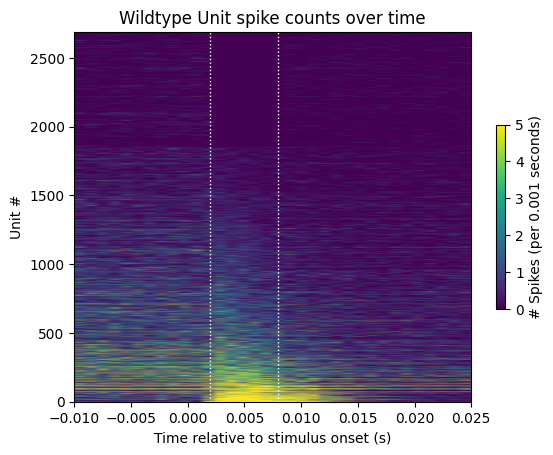

In [87]:
fig, axes = plt.subplots(1,1)

unit_response_means = np.mean(spike_counts[:, stim_start:stim_end], axis=1)
sorted_respons_idxs = np.argsort(unit_response_means)
sorted_sst_spike_counts = np.take(spike_counts, sorted_respons_idxs, axis=0)

show_counts(sorted_sst_spike_counts,
            bin_edges,
            figax = (fig, axes),
            stim_bounds=[censor_period, stim_duration-censor_period],
            title="Wildtype Unit spike counts over time",
            c_label=f"# Spikes (per {time_resolution} seconds)",
            vmin=0,
            vmax=5)

In [89]:
# calculate cell type metrics
# utility function used by first_spike_latencies_and_jitters and ks_salt
# returns an array of length 'start_times' with the first spike time after each `start_time` (and the censor period)
def get_first_spikes_after_onset(spike_times, start_times):
    
    response_start_times = start_times[start_times < spike_times.max()]

    first_spike_idxs = np.searchsorted(spike_times, response_start_times)
    first_spike_times = spike_times[first_spike_idxs] - response_start_times
    first_spike_times += censor_period
    
    return first_spike_times


def first_spike_latencies_and_jitters(spike_times, start_times):
    first_spike_times = get_first_spikes_after_onset(spike_times, start_times)
    
    first_spike_jitter = median_abs_deviation(first_spike_times)
    first_spike_latency = np.median(first_spike_times)
    
    return first_spike_jitter, first_spike_latency


def ks_salt(spike_times, start_times):
    first_spikes = get_first_spikes_after_onset(spike_times, start_times)
 
    # get first spikes at some time sufficiently prior the stimulus times so as to be a baseline period
    # but not too far back, for risk of sampling time during a previous stimulus event
    baseline_spikes = get_first_spikes_after_onset(spike_times, start_times-0.01)
    
    try:
        return kstest(first_spikes, baseline_spikes)[1]
    except:
        return np.nan
    
def fraction_time_responsive(unit_idx, spike_matrix, bl_trial_counts, stim_start_idx, stim_end_idx):
    bl_mean_count = np.mean(bl_trial_counts)
    
    bins_pvals = []
    bins_above_baseline = []
    
    for bin_idx in range(stim_start_idx, stim_end_idx):
        time_bin = spike_matrix[unit_idx, :, bin_idx]
        bins_pvals.append(mannwhitneyu(bl_trial_counts, time_bin)[1])
        bins_above_baseline.append(np.mean(time_bin) > bl_mean_count)

    num_sig_bins = np.sum( (np.array(bins_pvals)<0.01) & np.array(bins_above_baseline) )
    fraction_sig_bins = num_sig_bins / (stim_end_idx-stim_start_idx)
    return fraction_sig_bins


def fraction_trials_responsive(unit_idx, spike_matrix, bl_trial_counts, stim_start_idx, stim_end_idx, n_trials):
    bl_mean_count = np.mean(bl_trial_counts)
    
    trials_pvals = []
    trials_above_baseline = []
    
    for trial_idx in range(n_trials):
        trial = spike_matrix[unit_idx, trial_idx, stim_start_idx:stim_end_idx]
        trials_pvals.append(mannwhitneyu(bl_trial_counts, trial)[1])
        trials_above_baseline.append(np.mean(trial) > bl_mean_count)

    num_sig_trials = np.sum( (np.array(trials_pvals)<0.01) & np.array(trials_above_baseline) )
    fraction_sig_trials = num_sig_trials / n_trials
    return fraction_sig_trials

def get_opto_metrics(stim_times, units_spike_times, spike_counts, spike_matrix, censor_period, stim_start_idx, stim_end_idx, bl_start_idx, bl_end_idx):
    n_units = len(units_spike_times)
    n_trials = len(stim_times)
    start_times = np.array(stim_times) + censor_period

    # get mean response spike rate for each unit
    avg_spikes = spike_counts[:,stim_start_idx:stim_end_idx] / n_trials
    mean_response_spike_rates = np.mean(avg_spikes, axis=1)

    # these will be populated for each unit
    first_spike_jitters = np.zeros((n_units))
    first_spike_latencies = np.zeros((n_units))
    fracs_time_responsive = np.zeros((n_units))
    fracs_trials_responsive = np.zeros((n_units))
    salts = np.zeros((n_units))

    # populate each optotagging metric array for each unit
    for unit_idx in range(n_units):
        spike_times = units_spike_times[unit_idx]

        first_spike_jitter, first_spike_latency = first_spike_latencies_and_jitters(spike_times, start_times)

        first_spike_jitters[unit_idx] = first_spike_jitter
        first_spike_latencies[unit_idx] = first_spike_latency
        salts[unit_idx] = ks_salt(spike_times, start_times)

        # use the mean baseline spike counts for each trial to determine when the unit is 'responsive'
        bl_trial_counts = np.mean(spike_matrix[unit_idx, :, bl_start_idx:bl_end_idx], axis=0)
        fracs_time_responsive[unit_idx] = fraction_time_responsive(unit_idx, spike_matrix, bl_trial_counts, stim_start_idx, stim_end_idx)
        fracs_trials_responsive[unit_idx] = fraction_trials_responsive(unit_idx, spike_matrix, bl_trial_counts, stim_start_idx, stim_end_idx, n_trials)

    return mean_response_spike_rates, first_spike_jitters, first_spike_latencies, fracs_time_responsive, fracs_trials_responsive, salts

In [90]:
opto_metrics = get_opto_metrics(stim_times, spike_times, spike_counts, spike_matrix, censor_period, stim_start, stim_end, bl_start, bl_end)
mean_response_spike_rates, first_spike_jitters, first_spike_latencies, fracs_time_responsive, fracs_trials_responsive, salts = opto_metrics

df = pd.DataFrame({"mean response spike rate": mean_response_spike_rates,
                   "first spike jitter": first_spike_jitters,
                   "first spike latency": first_spike_latencies,
                   "fraction time responsive": fracs_time_responsive,
                   "fraction trials responsive": fracs_trials_responsive,
                   "ks salt value": salts
                  })
df

/Users/smprince/anaconda3/envs/hippie/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  return hypotest_fun_in(*args, **kwds)
/Users/smprince/anaconda3/envs/hippie/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/smprince/anaconda3/envs/hippie/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/50/_vs4yj0n27jbxcv71kvzktqr0000gp/T/ipykernel_22210/1449232571.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return kstest(first_spikes, baseline_spikes)[1]


,mean response spike rate,first spike jitter,first spike latency,fraction time responsive,fraction trials responsive,ks salt value
0,0.005556,0.116984,0.142129,0.000000,0.0,9.838897e-01
1,0.001111,2.385169,2.939082,0.000000,0.0,1.000000e+00
2,0.004444,0.175613,0.222239,0.666667,0.0,9.997797e-01
3,0.002222,0.116217,0.169636,0.333333,0.0,8.943205e-01
4,0.000000,1.520999,2.100958,0.000000,0.0,1.000000e+00
...,...,...,...,...,...,...
2683,0.095556,0.008516,0.011222,1.000000,0.0,2.897260e-14
2684,0.026667,1.608759,1.685899,0.000000,0.0,9.582445e-11
2685,0.018889,3.740164,4.082412,0.000000,0.0,1.060308e-02
2686,0.012222,1.896340,2.113569,0.000000,0.0,8.943205e-01


In [61]:
peak_channels = units.to_dataframe()['peak_channel_id']
electrodes_df = nwbfile.electrodes.to_dataframe()
brain_areas = electrodes_df.loc[peak_channels]['location']



Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5383],
      dtype='int64', name='id', length=2304)